In [281]:
#https://www.alphavantage.co/academy/#ai-for-finance

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries 

import requests
import pandas as pd
from pandas.io.json import json_normalize

print("All libraries loaded")

All libraries loaded


In [282]:
#Get Basic Stock Data

# Replace "demo" with your own API key from https://www.alphavantage.co/support/#api-key
apikey = "NA4DC7S59VGKCP4Y"
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&apikey={apikey}&outputsize=full'

# Send a GET request to the API
r = requests.get(url)
data = r.json()

# Extract the time series data
time_series = data['Time Series (Daily)']

# Create a DataFrame from the time series data
df = pd.DataFrame(time_series).T

# Rename the columns
df.columns = ['Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume', 'Dividend Amount', 'Split Coefficient']

# Convert the column data types
df = df.astype({
    'Open': float,
    'High': float,
    'Low': float,
    'Close': float,
    'Adjusted Close': float,
    'Volume': int,
    'Dividend Amount': float,
    'Split Coefficient': float
})

# Sort the DataFrame by date
df.sort_index(ascending=True, inplace=True)

# Reset the index
df.reset_index(inplace=True)

df.rename(columns={'index': 'Date'}, inplace=True)

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Specify the desired start and end dates
start_date = '2010-06-01'
end_date = '2023-06-30'

# Filter the DataFrame based on the start and end dates
filtered_basic = df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Reset the index without keeping the original index values
filtered_basic.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
print(filtered_basic.head)



<bound method NDFrame.head of            Date    Open    High      Low   Close  Adjusted Close   Volume  \
0    2010-06-01  124.69  126.88  124.200  124.34       75.027740  7135400   
1    2010-06-02  124.85  127.50  124.350  127.41       76.880202  7705300   
2    2010-06-03  127.75  128.22  126.460  127.96       77.212077  6645300   
3    2010-06-04  126.37  127.10  124.670  125.28       75.594944  9669200   
4    2010-06-07  125.57  125.86  124.130  124.13       74.901024  6951400   
...         ...     ...     ...      ...     ...             ...      ...   
3289 2023-06-26  129.39  131.41  129.310  131.34      131.340000  4845649   
3290 2023-06-27  131.30  132.95  130.830  132.34      132.340000  3219909   
3291 2023-06-28  132.06  132.17  130.910  131.76      131.760000  2753779   
3292 2023-06-29  131.75  134.35  131.690  134.06      134.060000  3639836   
3293 2023-06-30  134.69  135.03  133.425  133.81      133.810000  4236677   

      Dividend Amount  Split Coefficient  
0 

In [283]:
config = {
    "alpha_vantage": {
        "key": 'NA4DC7S59VGKCP4Y', # you can use the demo API key for this project, but please make sure to get your own API key at https://www.alphavantage.co/support/#api-key
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    },

    "alpha_vantage": {
        "symbol": "AAPL",  # Replace with your desired symbol
        "outputsize": "full",  # Replace with your desired output size
        "key_adjusted_close": "5. adjusted close"  # Replace with the appropriate key for adjusted close price
    },
    "plots": {
        "color_actual": "blue",  # Replace with your desired color
        "xticks_interval": 10,  # Replace with your desired interval for x-ticks
        "color_train": "#3D9970",  # Define the color for the training data
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    
    }

    
}

In [284]:
#Get inflation data

# Replace the "demo" API key below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=INFLATION&apikey=NA4DC7S59VGKCP4Y'
r = requests.get(url)
data = r.json()

# Convert the data to a pandas DataFrame
df = pd.DataFrame.from_dict(data)

# Normalize the "data" column
inflation = json_normalize(df['data'])

# Add the normalized data as columns to the DataFrame
df['date'] = inflation['date']
df['value'] = inflation['value']

# Rename the 'DATE' column to 'Date'
inflation.rename(columns={'date': 'Date'}, inplace=True)

# Filter the data based on the desired date range
start_date = '2010-06-01'
end_date = '2023-06-30'
filtered_inflation = inflation[(inflation['Date'] >= start_date) & (inflation['Date'] <= end_date)]



/var/folders/qy/3nm4yxds0yqgsybrtw7vhftm0000gn/T/ipykernel_7981/2785394002.py:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  inflation = json_normalize(df['data'])


In [285]:
#merge data

# Convert the 'Date' column in filtered_inflation to datetime
filtered_inflation['Date'] = pd.to_datetime(filtered_inflation['Date'])

import pandas as pd

# Merge the inflation dataset using concat
merged_data = pd.concat([filtered_basic.set_index('Date'), filtered_inflation.set_index('Date')['value']], axis=1, join='outer')

# Fill missing values for all columns
merged_data.fillna(method='ffill', inplace=True)
merged_data.fillna(method='bfill', inplace=True)

# Check missing values
missing_values = merged_data.isnull().sum()
print(missing_values)

# Convert "value" column to float
merged_data['value'] = merged_data['value'].astype(float)

# Display the merged DataFrame
print(merged_data)


Open                 0
High                 0
Low                  0
Close                0
Adjusted Close       0
Volume               0
Dividend Amount      0
Split Coefficient    0
value                0
dtype: int64
              Open    High      Low   Close  Adjusted Close     Volume  \
Date                                                                     
2010-06-01  124.69  126.88  124.200  124.34       75.027740  7135400.0   
2010-06-02  124.85  127.50  124.350  127.41       76.880202  7705300.0   
2010-06-03  127.75  128.22  126.460  127.96       77.212077  6645300.0   
2010-06-04  126.37  127.10  124.670  125.28       75.594944  9669200.0   
2010-06-07  125.57  125.86  124.130  124.13       74.901024  6951400.0   
...            ...     ...      ...     ...             ...        ...   
2023-06-26  129.39  131.41  129.310  131.34      131.340000  4845649.0   
2023-06-27  131.30  132.95  130.830  132.34      132.340000  3219909.0   
2023-06-28  132.06  132.17  130.910  131

/var/folders/qy/3nm4yxds0yqgsybrtw7vhftm0000gn/T/ipykernel_7981/832202225.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_inflation['Date'] = pd.to_datetime(filtered_inflation['Date'])


In [286]:


from sklearn.model_selection import train_test_split


x = merged_data[['Open', 'High','Low', 'Volume', 'Split Coefficient', 'value']]
y = merged_data['Close']

# Linear regression Model for stock prediction 
train_xGraph, test_xGraph, train_yGraph, test_yGraph = train_test_split(merged_data.index, y, test_size=0.15 , shuffle=False,random_state = 0)




In [287]:
# let's check if total observation makes sense
print(train_xGraph.shape )
print(test_xGraph.shape)
print(train_yGraph.shape)
print(test_yGraph.shape)

(2810,)
(496,)
(2810,)
(496,)


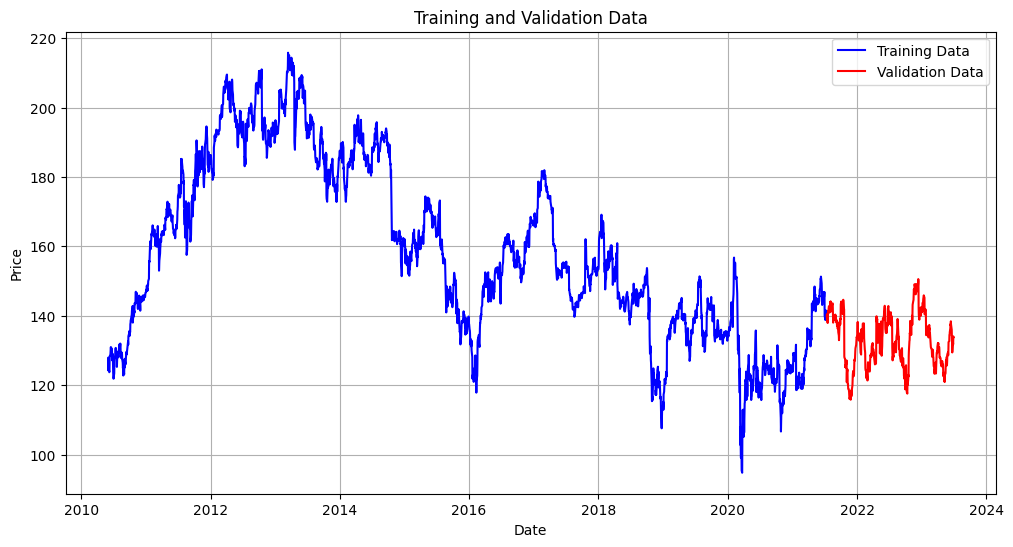

In [288]:

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_xGraph, train_yGraph, label="Training Data", color="blue")
plt.plot(test_xGraph, test_yGraph, label="Validation Data", color="red")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Training and Validation Data")
plt.legend()
plt.grid(True)
plt.show()

In [289]:
#Perform regression analysis



#Setup for regression analysis

x = merged_data[['Open', 'High','Low', 'Volume', 'Split Coefficient', 'value']]
y = merged_data['Close']


# Linear regression Model for stock prediction 
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.15 , shuffle=False,random_state = 0)

# let's check if total observation makes sense
print(train_x.shape )
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)



(2810, 6)
(496, 6)
(2810,)
(496,)


In [290]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score
regression = LinearRegression()
regression.fit(train_x, train_y)

print("regression coefficient",regression.coef_)
print("regression intercept",regression.intercept_)

# the coefficient of determination R²/ Cofidence of regression
regression_confidence = regression.score(train_x, train_y)
print("linear regression confidence: ", regression_confidence)


#Calculate predicted price
predicted=regression.predict(test_x)

dfr=pd.DataFrame({'Actual_Price':test_y, 'Predicted_Price':predicted})
dfr.tail(10)


#Acurracy of model
x2 = dfr.Actual_Price.mean()
y2 = dfr.Predicted_Price.mean()
Accuracy1 = x2/y2*100
print("The accuracy of the model is " , Accuracy1)


regression coefficient [-5.58333903e-01  7.90040346e-01  7.67143854e-01 -1.48266465e-08
  0.00000000e+00  6.74796578e-03]
regression intercept 0.21150199930718827
linear regression confidence:  0.9992193173128149
The accuracy of the model is  99.97121704558187


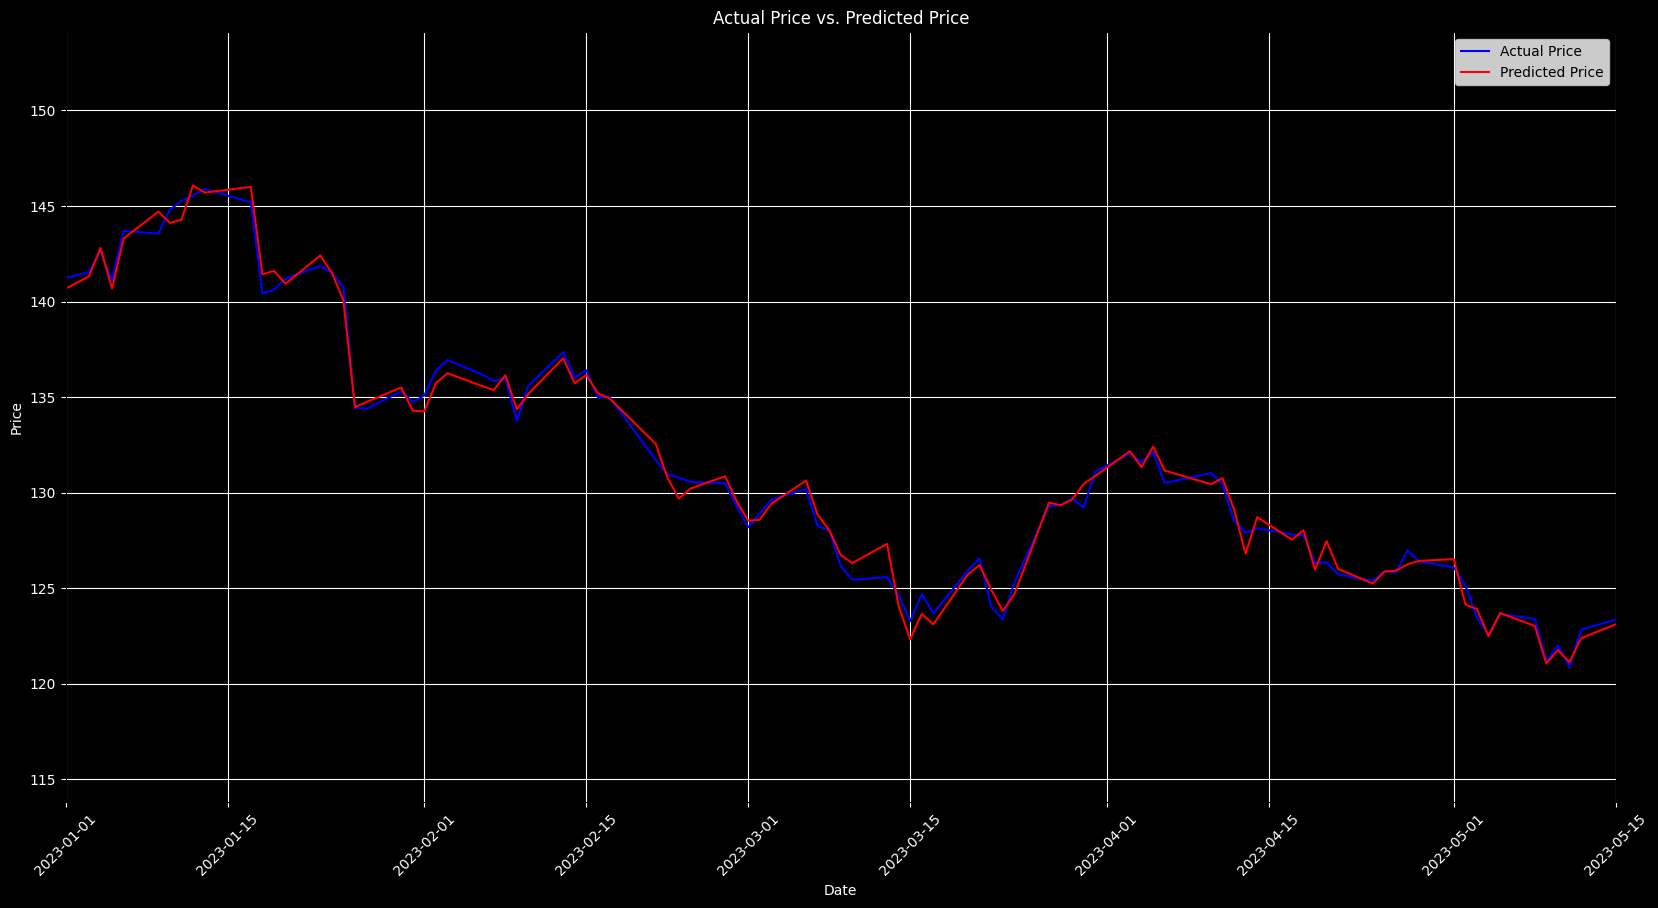

In [291]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Plotting the actual price and predicted price
fig, ax = plt.subplots(figsize=(20, 10), facecolor='black')
ax.set_facecolor('black')
ax.plot(dfr.index, dfr['Actual_Price'], label='Actual Price', color="blue")
ax.plot(dfr.index, dfr['Predicted_Price'], label='Predicted Price', color="red")
ax.set_xlabel('Date', color='white')
ax.set_ylabel('Price', color='white')
ax.set_title('Actual Price vs. Predicted Price', color='white')
ax.legend()
ax.grid(color='white')
ax.tick_params(colors='white')

# Set the desired date range
start_date = '2023-01-01'
end_date = '2023-05-15'
start_datetime = pd.to_datetime(start_date)
end_datetime = pd.to_datetime(end_date)
ax.set_xlim(start_datetime, end_datetime)

# Format the date ticks
date_formatter = DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_formatter)
plt.xticks(rotation=45)

plt.show()


In [373]:
# Normalize data
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=0)
        self.sd = np.std(x, axis=0)
        normalized_x = (x - self.mu) / self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x * self.sd) + self.mu


# Normalize
scaler = Normalizer()

normalized_data = scaler.fit_transform(merged_data)

# Create a new DataFrame with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=merged_data.columns, index=merged_data.index)

normalized_data_close_price = normalized_df['Close']








,Open,High,Low,Close,Adjusted Close,Volume,Dividend Amount,Split Coefficient,value
Date,,,,,,,,,
2010-06-01,-1.180096,-1.139681,-1.153907,-1.194710,-2.818585,0.905250,-0.121992,-0.017395,0.194613
2010-06-02,-1.173797,-1.115292,-1.148007,-1.073948,-2.677145,1.120819,-0.121992,-0.017395,0.194613
2010-06-03,-1.059627,-1.086969,-1.065009,-1.052313,-2.651805,0.719867,-0.121992,-0.017395,0.194613
2010-06-04,-1.113956,-1.131027,-1.135420,-1.157734,-2.775278,1.863677,-0.121992,-0.017395,0.194613
2010-06-07,-1.145451,-1.179806,-1.156661,-1.202971,-2.828260,0.835651,-0.121992,-0.017395,0.194613
...,...,...,...,...,...,...,...,...,...
2023-06-26,-0.995062,-0.961481,-0.952903,-0.919356,1.481014,0.039137,-0.121992,-0.017395,2.432932
2023-06-27,-0.919867,-0.900901,-0.893113,-0.880020,1.557366,-0.575810,-0.121992,-0.017395,2.432932
2023-06-28,-0.889946,-0.931585,-0.889966,-0.902835,1.513082,-0.752127,-0.121992,-0.017395,2.432932


In [293]:

def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # use the next day as label
    output = x[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price.values, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price.values, window_size=config["data"]["window_size"])

# split dataset
split_index = int(data_y.shape[0] * config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]


In [294]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (2628, 20, 1) (2628,)
Validation data shape (658, 20, 1) (658,)


In [295]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [296]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.056686, test:0.002038 | lr:0.010000
Epoch[2/100] | loss train:0.023042, test:0.001690 | lr:0.010000
Epoch[3/100] | loss train:0.014705, test:0.001125 | lr:0.010000
Epoch[4/100] | loss train:0.022973, test:0.001256 | lr:0.010000
Epoch[5/100] | loss train:0.016221, test:0.001319 | lr:0.010000
Epoch[6/100] | loss train:0.015358, test:0.004985 | lr:0.010000
Epoch[7/100] | loss train:0.018936, test:0.002297 | lr:0.010000
Epoch[8/100] | loss train:0.011307, test:0.002421 | lr:0.010000
Epoch[9/100] | loss train:0.021550, test:0.002645 | lr:0.010000
Epoch[10/100] | loss train:0.011425, test:0.007995 | lr:0.010000
Epoch[11/100] | loss train:0.012778, test:0.003518 | lr:0.010000
Epoch[12/100] | loss train:0.010052, test:0.001449 | lr:0.010000
Epoch[13/100] | loss train:0.009733, test:0.001759 | lr:0.010000
Epoch[14/100] | loss train:0.010178, test:0.001679 | lr:0.010000
Epoch[15/100] | loss train:0.010318, test:0.001541 | lr:0.010000
Epoch[16/100] | loss train:0.01064

In [381]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))



array([-1.0223515 , -1.16829777, -1.24818504, ..., -1.49897099,
       -1.38505936, -1.4185605 ])

In [396]:
len(predicted_train)

2628

In [395]:
# Assuming you have the normalized predictions stored in a variable called 'predicted_train'

# Reshape the predicted_train array if needed


# Unnormalize the predictions
predicted_unnormalized = scaler.inverse_transform(predicted_train.flatten())


ValueError: operands could not be broadcast together with shapes (2628,) (9,) 

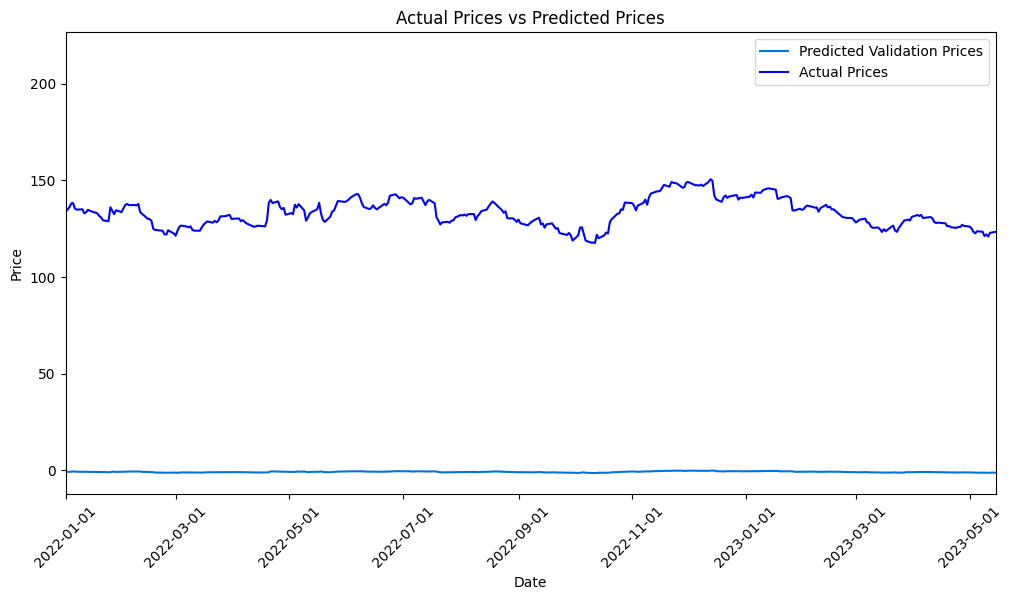

In [377]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

to_plot_data_y_train_pred = np.zeros_like(merged_data["Close"])
to_plot_data_y_val_pred = np.zeros_like(merged_data["Close"])

# Assign the predicted prices to the corresponding arrays for plotting
to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = predicted_train.flatten()
to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = predicted_val.flatten()

#scaler.inverse_transform(predicted_train)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)



# Plot the actual prices and predicted prices
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(merged_data.index, to_plot_data_y_val_pred, label="Predicted Validation Prices", color=config["plots"]["color_pred_val"])
ax.plot(merged_data.index, merged_data["Close"], label="Actual Prices", color=config["plots"]["color_actual"])
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Actual Prices vs Predicted Prices")
ax.legend()

# Set the desired date range
start_date = '2022-01-01'
end_date = '2023-05-15'
start_datetime = pd.to_datetime(start_date)
end_datetime = pd.to_datetime(end_date)
ax.set_xlim(start_datetime, end_datetime)

# Format the date ticks
date_formatter = DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_formatter)
plt.xticks(rotation=45)

plt.show()
